# Getting the Data for the Model

The main focus of this script will be to generate the predictions for each gameweek using XGBoost. To reiterate, some of the modelling concepts were inspired by the following resource: https://www.kaggle.com/code/gavinjpng/fpl-prediction-and-selection/notebook, and the relevant codes used can be found in Utils.

We will be comparing the effect of positional separation and bench selections.

In [24]:
import pandas as pd
import Utils
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [2]:
df = pd.read_csv('all_with_history.csv') #import the df we made with historical features

C:\Users\Tasha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
hist_features = []

#get the historical features into a list
for i in df.columns:
    if 'last' in i:
        hist_features.append(i)

In [4]:
#describing the different features to use in the model (coded it like this in case i have time to change the features later)
model_features = ['position', 'was_home', 'value', 'round','season_num'] + hist_features
categorical_features = ['position', 'was_home']
numerical_features = list(set(model_features)- set(categorical_features))

In [5]:
train = df[df.season != 2122] #all data since 2016 except 21/22 season
test = df[df.season == 2122]

In [6]:
X_train = Utils.get_categorical_labels(train[model_features], categorical_features, numerical_features)
X_train = X_train.loc[:,~X_train.columns.duplicated()].copy() 
#unsure what I did wrong here, but some cols were duplicated

y_train = train.total_points

X_test = Utils.get_categorical_labels(test, categorical_features, numerical_features)
y_test = test.total_points

# Finding The Hyper-Parameters

The hyper-parameter ranges shown below were decided through trial and error. While we haven't included the results to shorten the notebook, we reduced the range of each hyper-parameter list until the model stopped over-fitting. We determined this by printing the RandomisedGridSearch results of the 'get_position_model' function (see Utils)

We could have made more searches or used different ranges but we had to consider time.

In [7]:
params = {'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4],
          'max_depth': [2,4,6,8,10],
          'n_estimators': [50, 100, 200, 500],
          'min_child_weight': [1, 5, 10, 20, 30, 50, 100],
          'subsample': [0.6, 0.7, 0.8, 0.9, 1],
          'colsample_bytree': [0.6,0.7,0.8,0.9,1]}

## Modelling every position

The EDA showed that some features were less relevant for certain positions, although literature stated that XGBoost was quite good at determining which features were relevant, which is why we defined position as one of the model features. We wanted to test the effect of this however so have included both.

In [8]:
all_model, all_cv, all_predictions = Utils.get_position_model(df, 'all', params,
                                                              model_features, categorical_features, numerical_features)

In [9]:
all_predictions.sort_values('predicted', ascending = False)

,index,position,was_home,value,round,season_num,last_all_assists,last_1_assists,last_3_assists,last_5_assists,...,last_yr_saves,last_yr_transfers_in,last_yr_transfers_out,last_yr_yellow_cards,full_name,GW,player_team_name,total_points,actual,predicted
5591,120350,MID,True,126,3,5,2,0.0,2.0,2.0,...,0.0,6642020.0,5825059.0,0.0,mohamed_salah,3,Liverpool,10,10,6.136514
17063,131822,FWD,True,125,1,5,0,0.0,0.0,0.0,...,0.0,8181197.0,6160268.0,1.0,harry_kane,1,Tottenham Hotspur,0,0,6.018652
5589,120348,MID,False,125,1,5,0,0.0,0.0,0.0,...,0.0,6642020.0,5825059.0,0.0,mohamed_salah,1,Liverpool,17,17,6.007502
3079,117838,MID,True,120,2,5,0,0.0,0.0,0.0,...,0.0,2013619.0,2364727.0,3.0,sadio_mané,2,Liverpool,8,8,5.899636
5590,120349,MID,True,126,2,5,2,2.0,2.0,2.0,...,0.0,6642020.0,5825059.0,0.0,mohamed_salah,2,Liverpool,3,3,5.858489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23794,138553,GK,False,40,22,5,0,0.0,0.0,0.0,...,0.0,4560.0,2909.0,0.0,harry_lewis,22,Southampton,0,0,0.051403
24495,139254,MID,False,45,22,5,0,0.0,0.0,0.0,...,0.0,1291.0,960.0,0.0,kgaogelo_chauke,22,Southampton,0,0,0.051403
24501,139260,MID,False,45,28,5,0,0.0,0.0,0.0,...,0.0,1291.0,960.0,0.0,kgaogelo_chauke,28,Southampton,0,0,0.051403
9606,124365,GK,False,39,29,5,0,0.0,0.0,0.0,...,0.0,3775.0,6831.0,0.0,mark_gillespie,29,Newcastle United,0,0,0.051403


In [10]:
all_predictions.to_csv('all_predictions.csv')

## Modelling separate positions

In [13]:
fwd_model, fwd_cv, fwd_predictions = Utils.get_position_model(df,'FWD', params,
                                                              model_features, categorical_features, numerical_features)

In [15]:
mid_model, mid_cv, mid_predictions = Utils.get_position_model(df,'MID', params,
                                                              model_features, categorical_features, numerical_features)

In [17]:
def_model, def_cv, def_predictions = Utils.get_position_model(df,'DEF', params,
                                                              model_features, categorical_features, numerical_features)

In [18]:
gk_model, gk_cv, gk_predictions = Utils.get_position_model(df,'GK', params,
                                                              model_features, categorical_features, numerical_features)

In [40]:
fwd_predictions.sort_values('predicted', ascending = False).head(10).iloc[:,-6:]

,full_name,GW,player_team_name,total_points,actual,predicted
2281,harry_kane,4,Tottenham Hotspur,2,2,5.769427
2283,harry_kane,6,Tottenham Hotspur,2,2,5.665500
2285,harry_kane,8,Tottenham Hotspur,12,12,5.551690
2287,harry_kane,10,Tottenham Hotspur,2,2,5.476780
1255,jamie_vardy,2,Leicester City,2,2,5.467679
2288,harry_kane,11,Tottenham Hotspur,2,2,5.434415
1259,jamie_vardy,6,Leicester City,11,11,5.365604
2284,harry_kane,7,Tottenham Hotspur,2,2,5.350634
1257,jamie_vardy,4,Leicester City,2,2,5.342979
2286,harry_kane,9,Tottenham Hotspur,2,2,5.325667


In [41]:
mid_predictions.sort_values('predicted', ascending = False).head(10).iloc[:,-6:]

,full_name,GW,player_team_name,total_points,actual,predicted
2659,mohamed_salah,36,Liverpool,2,2,6.567684
2626,mohamed_salah,2,Liverpool,3,3,6.527360
2656,mohamed_salah,33,Liverpool,19,19,6.409646
2627,mohamed_salah,3,Liverpool,10,10,6.366085
2654,mohamed_salah,31,Liverpool,3,3,6.259819
2650,mohamed_salah,26,Liverpool,18,18,6.233255
2625,mohamed_salah,1,Liverpool,17,17,5.985319
1598,sadio_mané,3,Liverpool,5,5,5.890115
2645,mohamed_salah,22,Liverpool,0,0,5.856217
7073,heung_min_son,3,Tottenham Hotspur,10,10,5.855528


In [42]:
def_predictions.sort_values('predicted', ascending = False).head(10).iloc[:,-6:]

,full_name,GW,player_team_name,total_points,actual,predicted
5003,trent_alexander_arnold,26,Liverpool,6,6,6.406348
5007,trent_alexander_arnold,31,Liverpool,0,0,6.276974
1443,joão_pedro_cavaco_cancelo,38,Manchester City,1,1,6.004168
5009,trent_alexander_arnold,33,Liverpool,6,6,5.732365
5002,trent_alexander_arnold,26,Liverpool,0,0,5.691047
5006,trent_alexander_arnold,29,Liverpool,7,7,5.675766
1208,andrew_robertson,32,Liverpool,0,0,5.607847
5005,trent_alexander_arnold,29,Liverpool,6,6,5.596746
5000,trent_alexander_arnold,24,Liverpool,6,6,5.478375
1210,andrew_robertson,34,Liverpool,15,15,5.452721


In [43]:
gk_predictions.sort_values('predicted', ascending = False).head(10).iloc[:,-6:]

,full_name,GW,player_team_name,total_points,actual,predicted
1341,hugo_lloris,12,Tottenham Hotspur,4,4,4.726271
679,tim_krul,35,Norwich,2,2,4.553785
1340,hugo_lloris,11,Tottenham Hotspur,6,6,4.529798
1339,hugo_lloris,10,Tottenham Hotspur,1,1,4.522875
678,tim_krul,34,Norwich,2,2,4.504976
1869,jordan_pickford,8,Everton,3,3,4.504827
1885,jordan_pickford,27,Everton,4,4,4.390678
1868,jordan_pickford,7,Everton,3,3,4.280263
676,tim_krul,32,Norwich,9,9,4.265739
700,alisson_ramses_becker,17,Liverpool,2,2,4.264231


In [23]:
fwd_predictions.to_csv('fwd_predictions.csv')
mid_predictions.to_csv('mid_predictions.csv')
def_predictions.to_csv('def_predictions.csv')
gk_predictions.to_csv('gk_predictions.csv')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

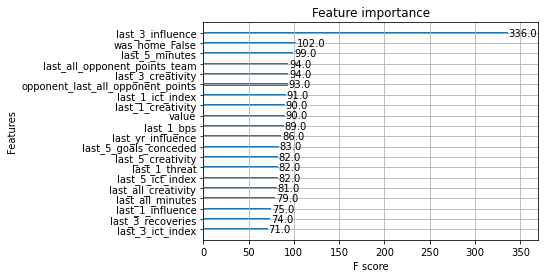

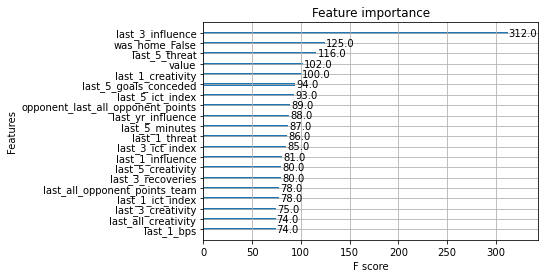

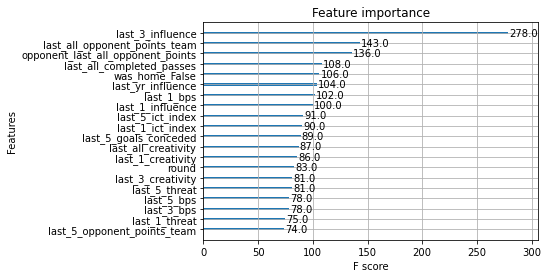

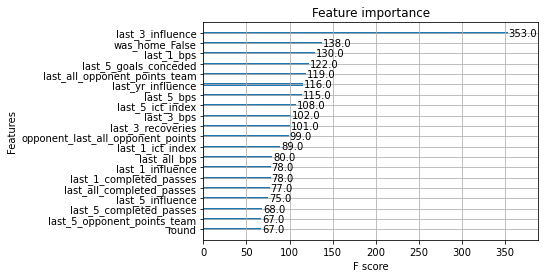

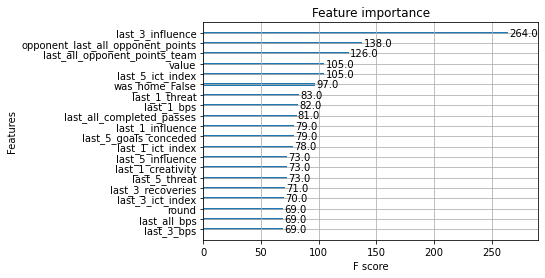

In [45]:
plot_importance(fwd_model,max_num_features = 20)
plot_importance(mid_model,max_num_features = 20)
plot_importance(def_model,max_num_features = 20)
plot_importance(gk_model,max_num_features = 20)
plot_importance(all_model,max_num_features = 20)